Welcome to the "Hello World" of recurrent neural networks (RNN).
In this notebook we will use RNNs to train a model that is able to forecast the stock price.

We will use TSLA stock price data from yahoo finance. 

We will need the following libraries to build and train the network. We will use keras of tensorflow 2.

In [1]:
import sys
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib 

Make sure we running python3 and tensorflow2.

In [2]:
print(f'Running python {sys.version}')
print(f'Running tensorflow {tf.__version__}')

Running python 3.8.6 (default, Oct 20 2020, 09:50:21) 
[Clang 11.0.3 (clang-1103.0.32.62)]
Running tensorflow 2.4.1


Check if you have GPU, enable it if so to make the training faster. Deep RNNs can be slow to train on CPU only computers. However this example is small and fast also with CPU only. If you are in google colab, go to menu Edit > Notebook settings, and make sure that you choose GPU as hardware accelerator. You might need to restart the kernel if you need to change that.

In [3]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15210446827671983019
]


Let's read and examine the dataset.

In [4]:
data_url = 'https://query1.finance.yahoo.com/v7/finance/download/TSLA?period1=1277769600&period2=1613520000&interval=1d&events=history&includeAdjustedClose=true'
tesla_stock = pd.read_csv(data_url)
tesla_stock

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
1,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
3,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
4,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...
2672,2021-02-09,855.119995,859.799988,841.750000,849.460022,849.460022,15157700
2673,2021-02-10,843.640015,844.820007,800.020020,804.820007,804.820007,36216100
2674,2021-02-11,812.440002,829.880005,801.729980,811.659973,811.659973,21580700
2675,2021-02-12,801.260010,817.330017,785.330017,816.119995,816.119995,23701700


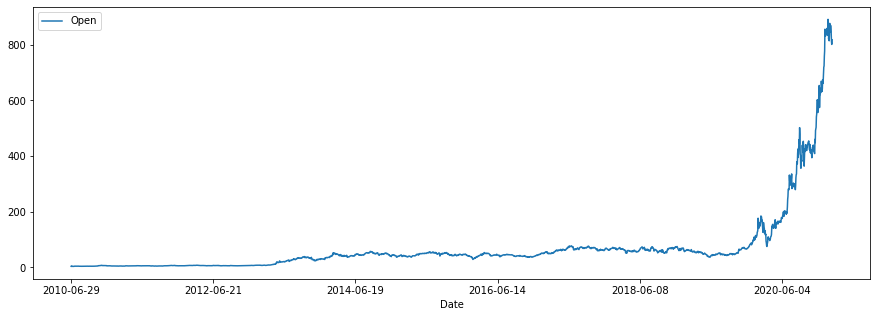

In [5]:
tesla_stock.plot(x='Date',y='Open',figsize=(15,5))

We will not use the first 1000 points, since there it was flat around 0 and doesn't contain much of useful history. We will focus on the opening price of the stocks.

In [6]:
to_drop_from_start = 1000
tesla_stock_data = tesla_stock.iloc[to_drop_from_start:, 1:2].values
print(tesla_stock_data)

[[ 45.776001]
 [ 45.703999]
 [ 45.902   ]
 ...
 [812.440002]
 [801.26001 ]
 [818.      ]]


As usual, networks are good with small numbers, typically around [0,1]. So we will need to scale our data. One option is min-max scaler, another option is the Standard scaler.

In [7]:
from sklearn.preprocessing import MinMaxScaler  
scaler = MinMaxScaler(feature_range=(0, 1))
tesla_stock_data_scaled = scaler.fit_transform(tesla_stock_data) 

In [8]:
days = np.linspace(1, len(tesla_stock_data), len(tesla_stock_data))

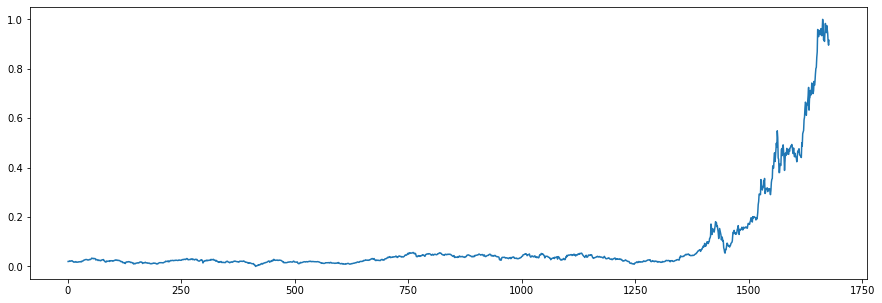

In [9]:
plt.figure(figsize=(15,5))
plt.plot(days, tesla_stock_data_scaled)

We will take the first 1000 points as training data, the rest for testing.

In this example we will make a sequence to value network, that uses the values from the past 50 days to predict the value of the next day.

In [10]:
past_days = 50
training_split = 1000
validation_split = 1300
features = []  
labels = []  
for i in range(0, training_split - past_days):  
    features.append(tesla_stock_data_scaled[i:i+past_days, 0])
    labels.append(tesla_stock_data_scaled[i+past_days, 0])
features=np.array(features)
labels=np.array(labels)

In [11]:
features = np.reshape(features, (features.shape[0], features.shape[1], 1))
features.shape

(950, 50, 1)

In [12]:
labels.shape

(950,)

In [13]:
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import (SimpleRNN, LSTM, GRU)
from tensorflow.keras.layers import Dropout  

We'll start with the simple rnn, and see how it performs.

In [14]:
model = Sequential()  
model.add(SimpleRNN(units=10, input_shape=(features.shape[1], 1),unroll=False)) 
model.add(Dropout(0.2)) 
model.add(Dense(units = 1))

In [15]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(features, labels, validation_split=0.2, epochs = 20, batch_size = 32)

Epoch 1/20
24/24 [==============================] - 0s 13ms/step - loss: 2.6756e-05 - val_loss: 1.8202e-05
Epoch 2/20
24/24 [==============================] - 0s 9ms/step - loss: 2.8952e-05 - val_loss: 2.0088e-05
Epoch 3/20
24/24 [==============================] - 0s 9ms/step - loss: 2.4181e-05 - val_loss: 1.7048e-05
Epoch 4/20
24/24 [==============================] - 0s 9ms/step - loss: 2.2962e-05 - val_loss: 1.6967e-05
Epoch 5/20
24/24 [==============================] - 0s 13ms/step - loss: 2.4655e-05 - val_loss: 1.6861e-05
Epoch 6/20
24/24 [==============================] - 0s 14ms/step - loss: 2.1942e-05 - val_loss: 1.9499e-05
Epoch 7/20
24/24 [==============================] - 0s 13ms/step - loss: 2.3081e-05 - val_loss: 1.7124e-05
Epoch 8/20
24/24 [==============================] - 0s 12ms/step - loss: 2.1111e-05 - val_loss: 2.0281e-05
Epoch 9/20
24/24 [==============================] - 0s 10ms/step - loss: 2.0965e-05 - val_loss: 1.6932e-05
Epoch 10/20
24/24 [=====================

In [248]:
# Uncomment this to save your trained model for later use
# If you are running a long training, it is good to have this in the same cell as model.fit
#model.save('tesla_model.h5')

# Then to load it back
#from tensorflow.keras.models import load_model
#model = load_model('tesla_model.h5')

# Note that the model does not contain the training history, but just the final weights
# So it is useful to save also the history using json.dump and json.load

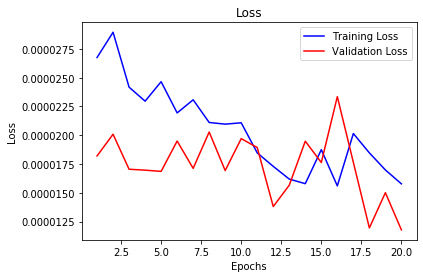

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'red', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
test_days = 500
testing = []
for i in range(training_split, training_split + test_days):  
    testing.append(tesla_stock_data_scaled[i:i+past_days, 0])
testing = np.array(testing)  
testing = np.reshape(testing, (testing.shape[0], testing.shape[1], 1))  
testing.shape

(500, 50, 1)

In [21]:
predictions = model.predict(testing) 
predictions = scaler.inverse_transform(predictions) 

In [22]:
actual = tesla_stock_data_scaled[training_split+past_days:training_split+past_days+test_days,0]
actual = actual.reshape(-1,1)
actual = scaler.inverse_transform(actual)

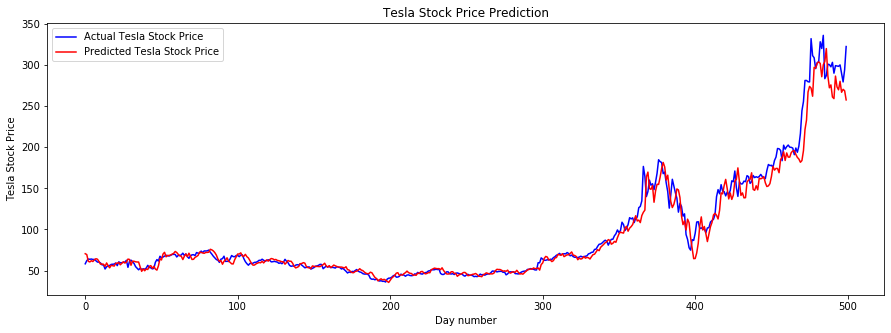

In [23]:
plt.figure(figsize=(15,5))  
plt.plot(actual, color='blue', label='Actual Tesla Stock Price')  
plt.plot(predictions , color='red', label='Predicted Tesla Stock Price')  
plt.title('Tesla Stock Price Prediction')  
plt.xlabel('Day number')  
plt.ylabel('Tesla Stock Price')  
plt.legend()  
plt.show() 

- Examine the notebook and run it.
- Play around with the parameters: number of nodes, number of epochs, dropout fraction.
- Replace the simple rnn with and LSTM, see if it is any better.
- Add one more LSTM layer (note that for all the recurrent layers, except the last one, you will need to pass return_sequences=True). Add a dropout afterwards.
- Homework: convert the notebook to sequence to sequence, i.e. make it predict the values of 5 days in one shot. You will need to slice the dataset correspondingly. Try on a different dataset, let's say exchange rates.